# Weight initialization
> See effects of various activation on the output stats (mean and std); find emprically 'good' `gain`s.

In [ ]:
#| hide
from fastai.basics import *
from ipywidgets import *
from IPython.display import clear_output

## Gain

Consider a standard FNN with hidden layers of equal size. A bad initialization of weights (biases are initialized to zeros) leads to _unstable_ signal flows, as the reponses after each layer may _explode_ or _vanish_. The key to the classical _Xavier_ initialization is the _variance scaling_ `sqrt(1/n)`, where `n = (fan_in + fan_out)/2` is of the order of the layer width. However, due to the effect of non-linear activations, a slight correction is necessary, aka `gain`, to ensure _zero-mean_ and _one-std_.

> We can either demand the __reponse__ (activation output) or the __net input__ to a neuron to have one-std. The results are the two functions `calc_gain_kumar` and `calc_gain` that compute the gain of an `actn` given values of it and its derivative evaluated at 0.

__refs__:

- [Kumar. On weight initialization in deep neural networks, 2017.](https://arxiv.org/abs/1704.08863)
- [pytorch forum](https://discuss.pytorch.org/t/calculate-gain-tanh/20854/4)

In [ ]:
calc_gain_kumar = lambda a,b: np.sqrt(1/(b*b*(1 + a*a)))  #a: f(0), b: f'(0)
calc_gain       = lambda a,b: np.sqrt(1/(a*a + b*b))

In [ ]:
#| hide
#| eval: false
selu_a=1.6732632423543772848170429916717
selu_s=1.0507009873554804934193349852946
vals = dict(sigmoid=(.5, .25), tanh=(0., 1.), softplus=(np.log(2), .5), softsign=(0., 1.),
            relu=(0., .5), elu=(0., 1.), selu=(0., selu_s*(1+selu_a)/2), silu=(0., .5), gelu=(0., .5))

hid_sz = 100
def tst_gain(actn, func, manual):
    clear_output()
    x = torch.randn(1000,hid_sz, requires_grad=True)
    a = z = x
    
    if float(manual) > 0: gain = float(manual)
    else: gain = calc_gain(*vals[actn]) if func == 'default' else calc_gain_kumar(*vals[actn])

    print(f"gain = {gain:.4f}\nin: mean={x.mean().item():7.4f}, std={x.std().item():.4f}\n")
    for i in range(101):
        l = torch.nn.Linear(hid_sz,hid_sz, bias=False)
        torch.nn.init.xavier_normal_(l.weight, gain)
        z = l(z)
        a = getattr(F, actn)(z)
        if i % 10 == 0:
            print (f"{i:3}: non-act-std={z.std().item():7.4f}, act-std={a.std().item():6.4f},", end=" ")
            x.grad = None
            z.sum().backward(retain_graph=True)
            print(f"grad={x.grad.abs().mean().item():.4f}")
        z = a

interact(tst_gain, actn=list(vals.keys()), func=['default','kumar'], manual='0');

interactive(children=(Dropdown(description='actn', options=('sigmoid', 'tanh', 'softplus', 'softsign', 'relu',…

## Dying ReLU

In [ ]:
#| hide
from wafer.layers import *
from wafer.callback.progress import *

Dying ReLU refers to the situation when a ReLU neuron is inactive for _all_ inputs during training (aka _dead_) after an erroneous weight update. When this happens in the _first_ layer and the whole layer is dead, the model stops learning. If this happens to any hidden layer, dead neurons may be reactivated.

For a __deep-and-narrow__ FNN-ReLU network, this problem is more severe.

In [ ]:
def lin(ni, no, actn=True):
    res = nn.Linear(ni, no)
    return nn.Sequential(res, nn.ReLU()) if actn else res
def mk_tst_model(ni, nh, no, n_layer=10):
    layers = [lin(ni, nh)] + [lin(nh, nh) for _ in range(1,n_layer-1)] + [lin(nh, no, False)]
    return nn.Sequential(*layers)

In [ ]:
#| eval: false
xs = (torch.rand(3000, 1)*2 - 1)*np.sqrt(3)
tst_db = DataBlock(get_x=lambda o: o[0:1], get_y=lambda o: o[1:2], splitter=RandomSplitter())
dls = tst_db.dataloaders(torch.hstack([xs, xs.abs()]), bs=32)

Common initialization methods, i.e. Xavier and He, `default_init`, does not help. `lsuv_init` or `orthogonal_` is slightly better.

Possible solutions:

- increase layer width (significant improvement).
- change activations.
- use ResNet-like architecture.

In [ ]:
tst_model = mk_tst_model(1,2,1)
default_init(tst_model)
# lsuv_init(tst_model, xb=dls.one_batch()[0])
# lambda_init(tst_model, lambda w,b: (nn.init.orthogonal_(w), nn.init.zeros_(b)))

In [ ]:
#| eval: false
crit = L1LossFlat()
lstats = LayerStatsCallback(grad=True)
learn = Learner(dls, tst_model, opt_func=Adam, loss_func=crit,
                cbs=[GradientFlowCallback(showbias=True), 
                     lstats])

epoch,train_loss,valid_loss,time
0,0.821530,0.832869,00:02
1,0.770739,0.769651,00:02
2,0.714807,0.712510,00:02
3,0.663580,0.660701,00:02
4,0.622444,0.614690,00:02


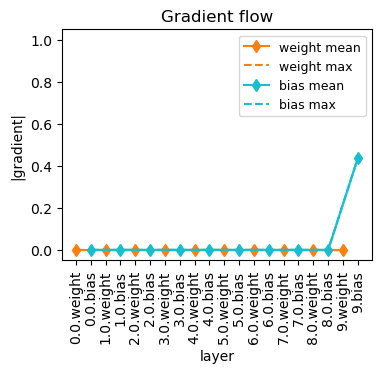

/Users/ydh/anaconda3/lib/python3.11/site-packages/torch/autograd/__init__.py:251: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1699448804225/work/aten/src/ATen/mps/MPSFallback.mm:13.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [ ]:
#| eval: false
learn.fit(5, 0.001)

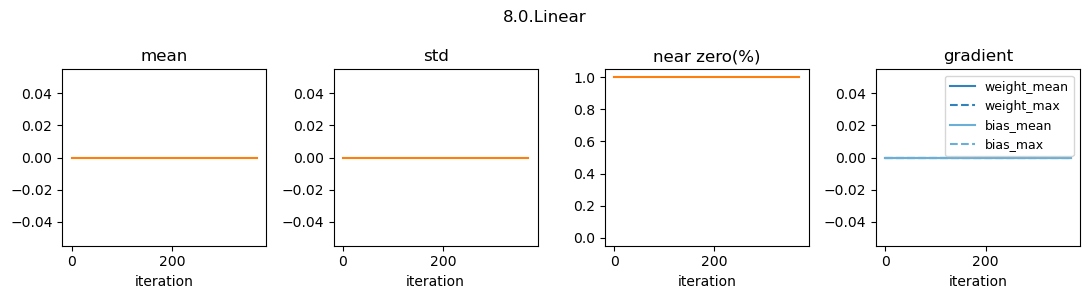

In [ ]:
#| eval: false
lstats.plot_layer(-2)

In [ ]:
#| hide
def show_preds(m, xb, yb):
    fig,ax = plt.subplots(figsize=(3,3))
    m.eval()
    with torch.inference_mode():
        preds = m(xb)
        ax.plot(xb.cpu(), yb.cpu(), '.', label='target')
        ax.plot(xb.cpu(), preds.cpu(), '.', label='pred')
        ax.legend(loc=1)

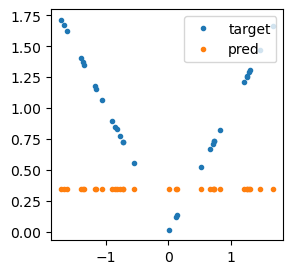

In [ ]:
#| eval: false
show_preds(tst_model, *dls.one_batch())

### RAI init

A new initialization, called _randomized asymmetric initializer_ (RAI) is proposed in [Lu Lu et al. Dying ReLU and Initialization: Theory and Numerical Examples, 2020](https://arxiv.org/abs/1903.06733) to alleviate the dying ReLU problem (lower probability of being "born-dead" or "train-to-dead"). It does so by tempering the _symmetric weight distribution_ found in common initialization schemes.

In [ ]:
tst_model = mk_tst_model(1,2,1)
rai_init(tst_model)

In [ ]:
#| eval: false
crit = L1LossFlat()
lstats = LayerStatsCallback(grad=True)
learn = Learner(dls, tst_model, opt_func=Adam, loss_func=crit,
                cbs=[GradientFlowCallback(showbias=True), 
                     lstats])

epoch,train_loss,valid_loss,time
0,0.436882,0.420780,00:02
1,0.431057,0.415467,00:02
2,0.422532,0.397625,00:02
3,0.393941,0.350813,00:02
4,0.313314,0.215302,00:02


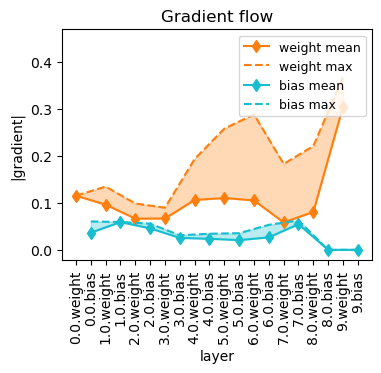

In [ ]:
#| eval: false
learn.fit(5, 0.001)

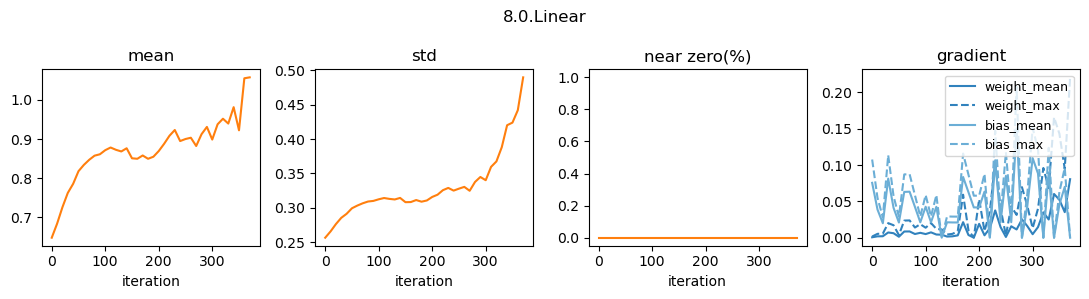

In [ ]:
#| eval: false
lstats.plot_layer(-2)

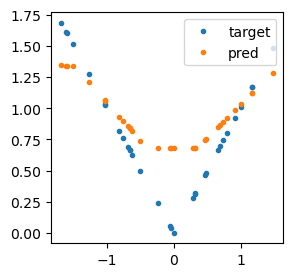

In [ ]:
#| eval: false
show_preds(tst_model, *dls.one_batch())